# Initialise main directory


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
main_dir = '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/'

!ls '{main_dir}'/.

Mounted at /content/gdrive
All_Data  Csv_Files	 Helper_Notebooks  Models
Audios	  Documentation  Main_Notebooks


# Install and import libraries

In [2]:
!pip install -q librosa
!pip install -q pysoundfile
!pip install -q -U keras-tuner

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf

import keras_tuner as kt
from ast import literal_eval

import os
import sys
import time
import shutil
from joblib import dump, load
import json

%matplotlib inline

import urllib.request as urllib2 # For python3
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import librosa
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from PIL import Image
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Obtain features and labels


In [4]:
label_target = {('mezzosoprano dramatic', 3), ('contraltos', 0), ('soprano coloratura', 5), 
                ('soprano spinto', 9), ('soprano lyric', 7), ('mezzosoprano lyric', 4), ('mezzosoprano coloratura', 2),
                ('soprano dramatic', 6), ('soprano soubrette', 8), ('countertenor', 1)}

labels = [item[0] for item in label_target]
# print(label_target)
# print(labels)

def targets_to_labels(list_to_convert):
  labels=[]
  for item in list_to_convert:
    for label, target in label_target:
      if item == target:
        labels.append(label)
  return labels

#function for removing problematic classes
def remove_problematic(to_remove, processed_data):
  for subregister in to_remove:
    for label, target in label_target:
      if subregister==label:
        processed_data = processed_data[processed_data['class_label'] != target]
  return processed_data

In [5]:
#read from mfccs data
processed_data = pd.read_csv(main_dir + "Csv_Files/females_500.csv")
processed_data = processed_data.sample(frac=1)
# print(processed_data.head())

to_evaluate = ['mezzosoprano coloratura', 'soprano soubrette', 'soprano coloratura']

# 'soprano dramatic',
# females_removed = [ 'soprano lyric',, 'mezzosoprano coloratura']
# other_notebook = ['mezzosoprano dramatic', 'countertenor', 'contraltos', 'mezzosoprano lyric']

to_remove = [item for item in labels if item not in to_evaluate]

processed_data = remove_problematic(to_remove, processed_data)
features = [literal_eval(processed_data['mfccs'].tolist()[i]) for i in range(len(processed_data))]
targets = processed_data["class_label"].tolist()
num_labels = len(set(targets))

print('Selected targets: ', set(targets))
print('Number of classes: ', num_labels )
print('To evaluate: ', to_evaluate)
print('Not considered: ', to_remove)

Selected targets:  {8, 2, 5}
Number of classes:  3
To evaluate:  ['mezzosoprano coloratura', 'soprano soubrette', 'soprano coloratura']
Not considered:  ['soprano dramatic', 'mezzosoprano lyric', 'mezzosoprano dramatic', 'contraltos', 'soprano lyric', 'countertenor', 'soprano spinto']


# Creating PCA components


Components 	 Fraction of explained variance
	 1 	 0.5248858558861148
	 2 	 0.6269723632234127
	 3 	 0.6951272231025856
	 4 	 0.7572714562557463
	 5 	 0.8092795632643848
	 10 	 0.9212382006166939
	 20 	 0.9788876467304933
	 25 	 0.9876299432426574
	 28 	 0.9907871007679954
	 30 	 0.9922663525485712
	 32 	 0.9934682356271002
	 40 	 0.996695897505837
	 50 	 0.9985096277701379




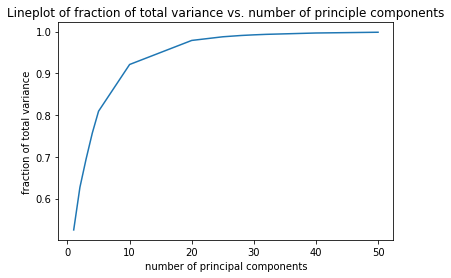

In [6]:
def get_pca_components(data):
  k = [1, 2, 3, 4, 5, 10, 20, 25, 28, 30, 32, 40, 50]
  explained_variances = []
  print('Components \t Fraction of explained variance')
  for components in k:
    pca = PCA(n_components = components)
    data_pc = pca.fit_transform(data)
    fraction_of_variance = sum(pca.explained_variance_ratio_)
    print('\t',components,'\t',fraction_of_variance)
    explained_variances.append(fraction_of_variance)
  print('\n')
  plt.plot(k, explained_variances)
  plt.xlabel("number of principal components")
  plt.ylabel("fraction of total variance")
  plt.title("Lineplot of fraction of total variance vs. number of principle components")
  plt.show()
  pass

get_pca_components(data = features)

# Train_Test_Split

In [7]:
components = 30
pca = PCA(n_components = components)
data_pca = pca.fit_transform(features)
dump(pca, main_dir + 'Models/Development/Females_B/PCA/Females_B_pca.joblib') 
print( data_pca[2])
print(data_pca.shape)


[ 10.79070728  -6.54968266 -22.00752472 -47.15109012  -2.82016117
  13.73159391  14.79189387   0.97694352 -11.94578077  13.97568042
  -7.36910333  14.8671118   -7.07071238   3.67234208   3.75781832
  13.2281794   -2.60331486  -3.5937947    3.32363673  -0.4661908
  -5.45090573   5.48043665  -2.23001865  -5.27524187  -0.93279247
   4.67237674  -2.38576411   1.39230548   1.62728071  -2.46445732]
(1471, 30)


In [8]:
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(data_pca)
dump(standard_scaler, main_dir + 'Models/Development/Females_B/Scaler/Females_B_scaler.joblib')
X = np.array(X)
y = np.array(targets)
y_encoded = LabelEncoder().fit_transform(y)
y_categorical = to_categorical(y_encoded)

mapping = list(set([item for item in zip(y_encoded, targets)]))
label_mapping = {}
for item in mapping:
  label_mapping[int(item[0])] = item[1]

dump(label_mapping, main_dir +  'Models/Development/Females_B/Reports/Females_B_label_mapping.joblib')

x_train, x_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.14)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size = 0.16)

print('x_train: ',len(x_train))
print('y_train: ', len(y_train))
print('x_test: ',len(x_test))
print('y_test: ',len(y_test))
print('x_dev: ',len(x_dev))
print('y_dev: ',len(y_dev))

datasets = [x_train, y_train, x_test, y_test, x_dev, y_dev]
dataset_names = ['x_train', 'y_train', 'x_test', 'y_test', 'x_dev', 'y_dev']
for dataset, dataset_name in zip(datasets, dataset_names):
  df = pd.DataFrame(dataset)
  folder = dataset_name.split('_')[1].capitalize()
  df.to_csv(main_dir + 'Models/Development/Females_B/Data/{0}/Females_B_{1}.csv'.format(folder, dataset_name), index=False)


x_train:  1062
y_train:  1062
x_test:  206
y_test:  206
x_dev:  203
y_dev:  203


# Keras Tuner

In [116]:
def model_builder(hp):
  lower = 8
  upper = 156
  step = 4

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(components), dtype=tf.float32,
                          name='input_embedding'))
  hp_units_1 = hp.Int('units_1', min_value=lower, max_value=upper, step=step)
  model.add(keras.layers.Dense(units=hp_units_1, activation='relu',name='dense_1'))
  # hp_reg_1 = hp.Float('regs_1', min_value=0.001, max_value=0.15, step=0.001)
  hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.8, step=0.1)
  model.add(keras.layers.Dropout(hp_dropout_1))

  # kernel_regularizer=regularizers.l2(hp_reg_1)
  # Tune the number of units in the Second Dense layer
  hp_units_2 = hp.Int('units_2', min_value=lower, max_value=upper, step=step)
  model.add(keras.layers.Dense(units=hp_units_2, activation='relu', name='dense_2'))
  # hp_reg_2 = hp.Float('regs_2', min_value=0.001, max_value=0.15, step=0.001)
  hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.8, step=0.1)
  model.add(keras.layers.Dropout(hp_dropout_2))

  # hp_units_3 = hp.Int('units_3', min_value=lower, max_value=upper, step=step)
  # model.add(keras.layers.Dense(units=hp_units_3, activation='relu', name='dense_3'))
  # # hp_reg_3 = hp.Float('regs_3', min_value=0.001, max_value=0.15, step=0.001)
  # hp_dropout_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.8, step=0.001)
  # model.add(keras.layers.Dropout(hp_dropout_3))


  hp_units_5 = hp.Int('units_5', min_value=lower, max_value=upper, step=step)
  # # hp_reg_3 = hp.Float('regs_3', min_value=0.001, max_value=0.1, step=0.001)
  # hp_dropout_5 = hp.Float('dropout_5', min_value=0.1, max_value=0.8, step=0.01)
  model.add(keras.layers.Dense(units=hp_units_5, activation='relu', name='dense_5'))
  # model.add(keras.layers.Dropout(hp_dropout_5))


  #Output_Layer
  model.add(keras.layers.Dense(num_labels, activation='softmax', name='output_layer'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[0.005, 1e-1, 1e-2, 1e-3, 1e-4])
  # hp_learning_rate = 0.001

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model

In [117]:

tuner_dir = main_dir + 'Main_Notebooks/Keras_Tuner_Approach/Females_Trials/Keras_Tuner/Females_B'
if os.path.exists(tuner_dir)==False:
  !mkdir "{tuner_dir}"

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=4,
                     directory=tuner_dir,
                     project_name='mk4')
print(tuner_dir)
print(tuner.project_name)

/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Main_Notebooks/Keras_Tuner_Approach/Females_Trials/Keras_Tuner/Females_B
mk4


In [118]:
!ls "{tuner_dir}"

mk0  mk1  mk2  mk3  mk4


In [119]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 156, 'step': 4, 'sampling': None}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': 0.1, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 156, 'step': 4, 'sampling': None}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': 0.1, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 156, 'step': 4, 'sampling': None}
learning_rate (Choice)
{'default': 0.005, 'conditions': [], 'values': [0.005, 0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [121]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)

In [122]:
tuner.search(x_train, y_train, epochs=160, validation_data=(x_dev, y_dev), callbacks=[stop_early])

Trial 161 Complete [00h 00m 04s]
val_accuracy: 0.6603053212165833

Best val_accuracy So Far: 0.7557252049446106
Total elapsed time: 00h 06m 15s
INFO:tensorflow:Oracle triggered exit


In [123]:
best_hps = tuner.get_best_hyperparameters()[0]


In [57]:
print('Layer1 units:', best_hps.get('units_1'))
# print('Layer1 l2 regularizer:', best_hps.get('regs_1'))
print('Layer1 dropout:', best_hps.get('dropout_1'))

print('Layer2 units:', best_hps.get('units_2'))
# print('Layer2 l2 regularizer:', best_hps.get('regs_2'))
print('Layer2 dropout:', best_hps.get('dropout_2'))

print('Layer3 units:', best_hps.get('units_3'))
# # print('Layer3 l2 regularizer:', best_hps.get('regs_3'))
# print('Layer3 dropout:', best_hps.get('dropout_3'))




# print('Learning Rate:', best_hps.get('learning_rate'))

Layer1 units: 96
Layer1 dropout: 0.2
Layer2 units: 92
Layer2 dropout: 0.4


KeyError: ignored

In [124]:
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 96)                2976      
                                                                 
 dropout_2 (Dropout)         (None, 96)                0         
                                                                 
 dense_2 (Dense)             (None, 88)                8536      
                                                                 
 dropout_3 (Dropout)         (None, 88)                0         
                                                                 
 dense_5 (Dense)             (None, 108)               9612      
                                                                 
 output_layer (Dense)        (None, 4)                 436       
                                                                 
Total params: 21,560
Trainable params: 21,560
Non-trai

In [125]:
h_history = h_model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=160)

Epoch 1/160
43/43 [==============================] - 1s 6ms/step - loss: 1.2566 - accuracy: 0.4210 - val_loss: 0.9176 - val_accuracy: 0.5992
Epoch 2/160
43/43 [==============================] - 0s 3ms/step - loss: 1.0040 - accuracy: 0.5637 - val_loss: 0.8613 - val_accuracy: 0.6489
Epoch 3/160
43/43 [==============================] - 0s 3ms/step - loss: 0.9155 - accuracy: 0.6198 - val_loss: 0.8269 - val_accuracy: 0.6527
Epoch 4/160
43/43 [==============================] - 0s 3ms/step - loss: 0.8474 - accuracy: 0.6322 - val_loss: 0.8160 - val_accuracy: 0.6565
Epoch 5/160
43/43 [==============================] - 0s 3ms/step - loss: 0.7982 - accuracy: 0.6533 - val_loss: 0.7764 - val_accuracy: 0.6603
Epoch 6/160
43/43 [==============================] - 0s 3ms/step - loss: 0.7286 - accuracy: 0.6803 - val_loss: 0.7291 - val_accuracy: 0.6908
Epoch 7/160
43/43 [==============================] - 0s 3ms/step - loss: 0.7212 - accuracy: 0.6890 - val_loss: 0.7440 - val_accuracy: 0.6870
Epoch 8/160
4

# Build Model Manually


In [9]:
def manual_model_builder():

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(components), dtype=tf.float32,
                          name='input_embedding'))
  # hp_units_1 = hp.Int('units_1', min_value=lower, max_value=upper, step=step)
  model.add(keras.layers.Dense(units=98, activation='relu',name='dense_1'))
  # hp_reg_1 = hp.Float('regs_1', min_value=0.001, max_value=0.15, step=0.001)
  # hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.8, step=0.1)
  model.add(keras.layers.Dropout(0.4))

  # kernel_regularizer=regularizers.l2(hp_reg_1)
  # regularizers.l2(hp_reg_3),
  # Tune the number of units in the Second Dense layer
  # hp_units_2 = hp.Int('units_2', min_value=lower, max_value=upper, step=step)
  model.add(keras.layers.Dense(units=94, activation='relu', name='dense_2'))
  # hp_reg_2 = hp.Float('regs_2', min_value=0.001, max_value=0.15, step=0.001)
  # hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.8, step=0.1)
  model.add(keras.layers.Dropout(0.4))

  model.add(keras.layers.Dense(units=42, activation='relu', name='dense_3'))
  # # # hp_reg_3 = hp.Float('regs_3', min_value=0.001, max_value=0.15, step=0.001)
  # # # hp_dropout_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.8, step=0.1)
  # model.add(keras.layers.Dropout(0.5))

  # model.add(keras.layers.Dense(units=48, activation='relu', name='dense_4'))

  #Output_Layer
  model.add(keras.layers.Dense(num_labels, activation='softmax', name='output_layer'))
  hp_learning_rate = 0.0005

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model

manual_model = manual_model_builder()
manual_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 98)                3038      
                                                                 
 dropout (Dropout)           (None, 98)                0         
                                                                 
 dense_2 (Dense)             (None, 94)                9306      
                                                                 
 dropout_1 (Dropout)         (None, 94)                0         
                                                                 
 dense_3 (Dense)             (None, 42)                3990      
                                                                 
 output_layer (Dense)        (None, 3)                 129       
                                                                 
Total params: 16,463
Trainable params: 16,463
Non-traina

In [10]:
manual_history = manual_model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=160)

Epoch 1/160
34/34 [==============================] - 1s 9ms/step - loss: 1.2037 - accuracy: 0.3437 - val_loss: 1.0911 - val_accuracy: 0.3842
Epoch 2/160
34/34 [==============================] - 0s 3ms/step - loss: 1.0987 - accuracy: 0.4143 - val_loss: 1.0620 - val_accuracy: 0.4236
Epoch 3/160
34/34 [==============================] - 0s 3ms/step - loss: 1.0775 - accuracy: 0.4228 - val_loss: 1.0303 - val_accuracy: 0.4926
Epoch 4/160
34/34 [==============================] - 0s 3ms/step - loss: 1.0357 - accuracy: 0.4708 - val_loss: 0.9993 - val_accuracy: 0.5419
Epoch 5/160
34/34 [==============================] - 0s 3ms/step - loss: 1.0109 - accuracy: 0.4878 - val_loss: 0.9610 - val_accuracy: 0.5714
Epoch 6/160
34/34 [==============================] - 0s 3ms/step - loss: 0.9993 - accuracy: 0.4878 - val_loss: 0.9224 - val_accuracy: 0.5961
Epoch 7/160
34/34 [==============================] - 0s 3ms/step - loss: 0.9483 - accuracy: 0.5414 - val_loss: 0.8865 - val_accuracy: 0.6305
Epoch 8/160
3

# Model Performance


In [11]:
model = manual_model
history = manual_history

# model = h_model
# history = h_history


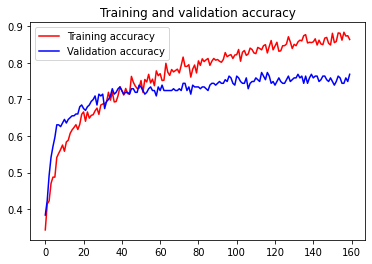

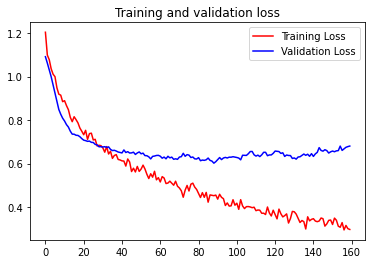

In [12]:
def model_performance(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')

  plt.legend()
  plt.show()
  pass

model_performance(history)


In [13]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)


7/7 [==============================] - 0s 2ms/step - loss: 0.7026 - accuracy: 0.7476
Test Loss:  0.7025600671768188
Test Accuracy:  0.7475728392601013


206
                         precision    recall  f1-score   support

mezzosoprano coloratura       0.76      0.89      0.82        61
     soprano coloratura       0.76      0.70      0.73        76
      soprano soubrette       0.72      0.68      0.70        69

               accuracy                           0.75       206
              macro avg       0.75      0.75      0.75       206
           weighted avg       0.75      0.75      0.75       206

0.8986008395713037
[0.93894856 0.88866397 0.86818999]


['/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Development/Females_B/Reports/Females_B_performance_report.joblib']

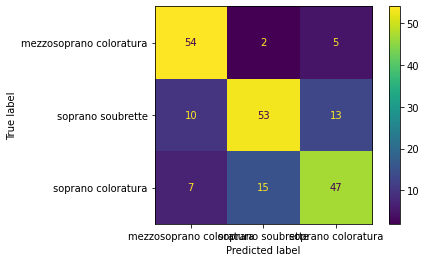

In [16]:
y_pred = model.predict(x_test)
print(len(y_pred))
y_pred_list = [y_pred[i].argmax() for i in range(len(x_test))]
y_true_list = [y_test[i].argmax() for i in range(len(x_test))]

label_mapping = load(main_dir +  'Models/Development/Females_B/Reports/Females_B_label_mapping.joblib')

y_pred_list = [label_mapping[item] for item in y_pred_list]
y_true_list = [label_mapping[item] for item in y_true_list]

true_labels = targets_to_labels(y_true_list)
pred_labels = targets_to_labels(y_pred_list)

# print(len(true_labels))
# print(len(pred_labels))


conf_matrix = metrics.confusion_matrix(true_labels, pred_labels)
cm = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels=to_evaluate).plot()
precision, recall, f_score, _ = metrics.precision_recall_fscore_support(y_true_list, y_pred_list, average='macro')
con_mat_norm = np.around(conf_matrix.astype('int') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

performance_report = {}
performance_report['precision'] = precision
performance_report['recall'] = recall
performance_report['f_score'] = f_score
performance_report['conf_matrix'] = conf_matrix
performance_report['classification_report'] = metrics.classification_report(true_labels,pred_labels)
performance_report['avg_roc_auc_score'] = metrics.roc_auc_score(y_test,y_pred, multi_class='ovr')
performance_report['spcfc_roc_auc_score'] = metrics.roc_auc_score(y_test,y_pred, average=None ,multi_class='ovr')

print(performance_report['classification_report'])
print(performance_report['avg_roc_auc_score'])
print(performance_report['spcfc_roc_auc_score'])

dump(performance_report, main_dir +  'Models/Development/Females_B/Reports/Females_B_performance_report.joblib')


# Save the model

In [17]:
model.save(main_dir + 'Models/Development/Females_B/ANN/Females_B')
print('Development Model Saved')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Development/Females_B/ANN/Females_B/assets
Development Model Saved


# Save the Model to Production

In [18]:
#save models used

dump(pca, main_dir + 'Models/Production/Females_B/PCA/Females_B_pca.joblib') 
print('pca model saved')
dump(standard_scaler, main_dir + 'Models/Production/Females_B/Scaler/Females_B_scaler.joblib')
print('scaler model saved')
model.save(main_dir + 'Models/Production/Females_B/ANN/Females_B')
print('ANN model saved')
dump(label_mapping, main_dir +  'Models/Production/Females_B/Reports/Females_B_label_mapping.joblib')
print('Label mapping saved')
dump(performance_report, main_dir +  'Models/Production/Females_B/Reports/Females_B_performance_report.joblib')
print('Performance report saved')

# save data used
for dataset, dataset_name in zip(datasets, dataset_names):
  df = pd.DataFrame(dataset)
  folder = dataset_name.split('_')[1].capitalize()
  df.to_csv(main_dir + 'Models/Production/Females_B/Data/{0}/Females_B_{1}.csv'.format(folder, dataset_name), index=False)

print('Datasets used saved')

pca model saved
scaler model saved
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Females_B/ANN/Females_B/assets
ANN model saved
Label mapping saved
Performance report saved
Datasets used saved
